# **STAT 587 &mdash; Data Science I** &mdash; Homework 2
**Winter 2026**

### Imports & Setup

In [1]:
import sys
from pathlib import Path

# Add project root to Python path
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

# Ensure output directories exist
from src.paths import ensure_dirs, DATA_DIR, FIG_DIR, TAB_DIR

ensure_dirs()

In [2]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from ISLP import load_data

In [3]:
# Set Seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [4]:
# GLOBAL OUTPUT CONTROLS

VERBOSE = True           # print / display intermediate outputs
SAVE_FIGS = True         # write figures to reports/figures
SAVE_TABLES = True       # write tables to reports/tables

### Helper Functions

In [5]:
# FLAG HELPERS


# OUTPUT
def vprint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)


# FIGURES
def save_fig(fig, filename, *, show=None, dpi=300):
    """Optionally save matplotlib figure to reports/figures and close it."""
    if show is None:
        show = VERBOSE
    
    if SAVE_FIGS:
        path = FIG_DIR / filename
        fig.savefig(path, dpi=dpi, bbox_inches="tight")
        if show:
            plt.show()        
        plt.close(fig)
        return path
    if show:
        plt.show()
    plt.close(fig)
    return None


# LaTex TABLES
def latex_escape_underscores(s):
    """Escape underscores for LaTeX."""
    return str(s).replace("_", r"\_")


def escape_df_underscores(df, cols=("Predictor",)):
    """Escape underscores in specified string columns (returns a copy)."""
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = out[c].astype(str).apply(latex_escape_underscores)
    return out


def df_to_tabular_tex(df, *, float_fmt="%.4f", index=True):
    """Return LaTeX tabular with booktabs formatting."""
    return df.to_latex(
        index=index,
        escape=False,
        float_format=(lambda x: float_fmt % x) if float_fmt else None,
        bold_rows=False,
        longtable=False,
    )


def wrap_table(tabular_tex, *, caption, label):
    """Wrap a tabular in a standalone LaTeX table environment."""
    return "\n".join(
        [
            r"\begin{table}[H]",
            r"\begin{center}",
            tabular_tex.strip(),
            r"\end{center}",
            r"\vspace{-5pt}",
            rf"\caption{{{caption}}}",
            rf"\label{{{label}}}",
            r"\end{table}",
            "",
        ]
    )


def save_tex_table(
    df,
    filename,
    *,
    caption,
    label,
    float_fmt="%.4f",
    index=False,
    escape_underscore_cols=None,
):
    """Optionally save a DataFrame as a LaTeX table to reports/tables."""
    if not SAVE_TABLES:
        return None

    if escape_underscore_cols:
        df = escape_df_underscores(df, cols=escape_underscore_cols)

    tex = wrap_table(
        df_to_tabular_tex(df, float_fmt=float_fmt, index=index),
        caption=caption,
        label=label,
    )
    path = TAB_DIR / filename
    path.write_text(tex)
    return path

---
---

## **Question 1:** College Data (ISLP)


Consider the College data from the ISLP package. Details about the data is described on page 65 of the ISLP textbook for this class (https://islp.readthedocs.io/en/latest/datasets/College.html). We would like to *predict* the *number of applications* received using the other variables. 80% of the data (randomly generated) will be treated as training data. The rest will be the test data.

- **Part (a):** Fit a linear model using least squares and report the estimate of the test error.  

- **Part (b):** Fit a tree to the data. Summarize the results. Unless the number of terminal nodes is large, display the tree graphically. Report its MSE.  

- **Part (c):** Use cross-validation to determine whether pruning is helpful and determine the optimal size for the pruned tree. Compare the pruned and un-pruned trees. Report MSE for the pruned tree. Which predictors seem to be the most important?  

- **Part (d):** Use a bagging approach to analyze the data with B = 500 and B = 1000. Compute the MSE. Which predictors seem to be the most important?  

- **Part (e):** Repeat (d) with a random forest approach with B = 500 and B = 1000, and $m \approx p = 3$.  

- **Part (f):** Compare the results from the various methods. Which method would you recommend?

### Q1-Specific Helper Functions and Shared Objects

In [6]:
def save_importance_table(
    feature_names,
    importances,
    *,
    filename_tex,
    caption,
    label,
    top_k=None,
):
    imp_df = (
        pd.DataFrame({"Predictor": feature_names, "Importance": importances})
        .sort_values("Importance", ascending=False)
        .reset_index(drop=True)
    )
    if top_k is not None:
        imp_df = imp_df.head(top_k).copy()

    # save LaTeX table
    save_tex_table(
        imp_df,
        filename_tex,
        caption=caption,
        label=label,
        float_fmt="%.4f",
        index=False,
        escape_underscore_cols=("Predictor",),
    )
    return imp_df


def save_importance_plot(
    feature_names,
    importances,
    *,
    filename_png,
    title,
    top_k=None,
):
    imp_df = (
        pd.DataFrame({"Predictor": feature_names, "Importance": importances})
        .sort_values("Importance", ascending=False)
        .head(top_k)
        .copy()
    )

    if top_k is not None:
        imp_df = imp_df.head(top_k).copy()

    # Use unescaped names for plotting
    imp_df_plot = imp_df.iloc[::-1]

    fig, ax = plt.subplots(figsize=(8, 11))
    ax.barh(imp_df_plot["Predictor"], imp_df_plot["Importance"])
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Feature importance", fontsize=12, labelpad=10)
    ax.tick_params(axis="y", labelsize=9)
    ax.grid(True, axis="x", alpha=0.3)

    if SAVE_FIGS:
        save_fig(fig, filename_png)
    else:
        plt.close(fig)

    return imp_df

### Data Load, Initial Inspection, Split, Preprocessing

In [7]:
# Load data
q1_df = load_data("College").copy()

In [8]:
# Initial Checks

# Target Column Name
q1_y_col = "Apps"

assert len(q1_df) > 0, "College dataset is empty."
assert q1_y_col in q1_df.columns, f"Target variable '{q1_y_col}' not found."

n_missing = int(q1_df.isna().sum().sum())
assert (
    n_missing == 0
), f"Missing values exist in College data: total missing = {n_missing}"

assert (q1_df[q1_y_col] > 0).all(), "Applications count must be positive."

# Predictors/target
q1_X = q1_df.drop(columns=[q1_y_col])
q1_y = q1_df[q1_y_col].to_numpy()

# Identify categorical vs numeric columns (predictors)
q1_cat_cols = q1_X.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()
q1_num_cols = [c for c in q1_X.columns if c not in q1_cat_cols]

assert len(q1_num_cols) + len(q1_cat_cols) == q1_X.shape[1]
assert all(pd.api.types.is_numeric_dtype(q1_X[c]) for c in q1_num_cols)

# Categorical sanity (specific known field)
if "Private" in q1_X.columns:
    assert set(q1_X["Private"].astype(str).unique()) == {
        "Yes",
        "No",
    }, "Unexpected levels in 'Private' variable."

In [9]:
# Initial EDA summary

# Categorical levels
q1_cat_levels = {}
for col in q1_cat_cols:
    q1_cat_levels[col] = sorted(q1_df[col].astype(str).unique().tolist())

q1_cat_levels_str = (
    "; ".join([f"{col}:" + "|".join(levels) for col, levels in q1_cat_levels.items()])
    if q1_cat_levels
    else "(none)"
)

# Numeric ranges (predictors)
q1_num_summary = q1_df[q1_num_cols].describe().T
q1_num_ranges_str = (
    "; ".join(
        [
            f"{col}[{q1_num_summary.loc[col, 'min']:.0f},{q1_num_summary.loc[col, 'max']:.0f}]"
            for col in q1_num_summary.index
        ]
    )
    if len(q1_num_cols) > 0
    else "(none)"
)

# Target summary
q1_apps_summary = q1_df[q1_y_col].describe()
q1_apps_str = (
    f"min={q1_apps_summary['min']:.0f}, "
    f"q1={q1_apps_summary['25%']:.0f}, "
    f"median={q1_apps_summary['50%']:.0f}, "
    f"mean={q1_apps_summary['mean']:.1f}, "
    f"q3={q1_apps_summary['75%']:.0f}, "
    f"max={q1_apps_summary['max']:.0f}"
)

q1_eda_summary = pd.DataFrame(
    {
        "item": [
            "n_rows",
            "n_cols",
            "columns",
            "categorical_cols",
            "categorical_levels",
            "numeric_cols",
            "numeric_ranges_minmax",
            "target",
            "target_summary",
        ],
        "value": [
            q1_df.shape[0],
            q1_df.shape[1],
            ", ".join(q1_df.columns.astype(str).tolist()),
            ", ".join(q1_cat_cols) if q1_cat_cols else "(none)",
            q1_cat_levels_str,
            ", ".join(q1_num_cols) if q1_num_cols else "(none)",
            q1_num_ranges_str,
            q1_y_col,
            q1_apps_str,
        ],
    }
)

if VERBOSE:
    display(q1_eda_summary)

,item,value
0,n_rows,777
1,n_cols,18
2,columns,"Private, Apps, Accept, Enroll, Top10perc, Top2..."
3,categorical_cols,Private
4,categorical_levels,Private:No|Yes
5,numeric_cols,"Accept, Enroll, Top10perc, Top25perc, F.Underg..."
6,numeric_ranges_minmax,"Accept[72,26330]; Enroll[35,6392]; Top10perc[1..."
7,target,Apps
8,target_summary,"min=81, q1=776, median=1558, mean=3001.6, q3=3..."


In [10]:
# Train/test split (80/20)
q1_X_train, q1_X_test, q1_y_train, q1_y_test = train_test_split(
    q1_X, q1_y, test_size=0.2, random_state=SEED
)

# Checks
assert q1_X_train.shape[0] + q1_X_test.shape[0] == q1_df.shape[0]
assert q1_y_train.shape[0] + q1_y_test.shape[0] == q1_df.shape[0]

In [11]:
# Shared Preprocessing
q1_preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", q1_num_cols),
        ("cat", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), q1_cat_cols),
    ],
    remainder="drop",
)

### **1(a)** Least Squares Linear Regression

In [12]:
# Fit a Least Squares Linear Model
q1a_lm = Pipeline(
    steps=[
        ("preprocess", q1_preprocess),
        ("model", LinearRegression()),
    ]
)

q1a_lm.fit(q1_X_train, q1_y_train)
assert hasattr(q1a_lm.named_steps["model"], "coef_"), "Error in lm fit."

# Predictions
q1a_y_train_pred = q1a_lm.predict(q1_X_train)
q1a_y_test_pred = q1a_lm.predict(q1_X_test)

# MSE
q1a_train_mse = mean_squared_error(q1_y_train, q1a_y_train_pred)
q1a_test_mse = mean_squared_error(q1_y_test, q1a_y_test_pred)

assert q1a_train_mse >= 0 and q1a_test_mse >= 0

In [13]:
# Save Train/Test Error Table (LaTeX)
q1a_mse_tbl = pd.DataFrame(
    {
        "Metric": ["Train MSE", "Test MSE"],
        "Value": [q1a_train_mse, q1a_test_mse],
    }
)

_ = save_tex_table(
    q1a_mse_tbl,
    "q1a_lm_mse.tex",
    caption="Train and test mean squared error (MSE) for the least squares linear regression model.",
    label="tab:q1a-lm-mse",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q1a_mse_tbl)

,Metric,Value
0,Train MSE,9.901060e+05
1,Test MSE,1.492443e+06


In [14]:
# Sanity check from large MSEs
q1a_train_rmse = float(np.sqrt(q1a_train_mse))
q1a_test_rmse = float(np.sqrt(q1a_test_mse))

if VERBOSE:    
    print(f"Train RMSE: {q1a_train_rmse:.4f}")
    print(f"Test  RMSE:  {q1a_test_rmse:.4f}")

Train RMSE: 995.0407
Test  RMSE:  1221.6560


In [15]:
# Extract fitted linear model
q1a_lr = q1a_lm.named_steps["model"]

# Get feature names after preprocessing
q1a_feature_names = q1a_lm.named_steps["preprocess"].get_feature_names_out()

# Build coefficient table
q1a_coef_tbl = pd.DataFrame(
    {
        "Predictor": ["Intercept"] + q1a_feature_names.tolist(),
        "Coefficient": np.concatenate(([q1a_lr.intercept_], q1a_lr.coef_)),
    }
)

# Sanity check
assert q1a_coef_tbl.shape[0] == len(q1a_lr.coef_) + 1

# Optionally save Coefficient Table
_ = save_tex_table(
    q1a_coef_tbl,
    "q1a_lm_coefficients.tex",
    caption="Estimated coefficients for the least squares linear regression model predicting number of applications.",
    label="tab:q1a-lm-coefficients",
    float_fmt="%.4f",
    index=False,
    escape_underscore_cols=("Predictor",),
)

if VERBOSE:
    display(q1a_coef_tbl)

,Predictor,Coefficient
0,Intercept,-58.980160
1,num__Accept,1.665580
2,num__Enroll,-1.030623
3,num__Top10perc,51.706571
4,num__Top25perc,-14.992375
5,num__F.Undergrad,0.056473
6,num__P.Undergrad,-0.026297
7,num__Outstate,-0.071223
8,num__Room.Board,0.157684
9,num__Books,0.112882


### **1(b)** Regression Tree

In [16]:
# Fit Unpruned Regression Tree
q1b_tree = Pipeline(
    steps=[
        ("preprocess", q1_preprocess),
        ("model", DecisionTreeRegressor(random_state=SEED)),
    ]
)

q1b_tree.fit(q1_X_train, q1_y_train)
assert hasattr(q1b_tree.named_steps["model"], "tree_")

# Predictions
q1b_y_train_pred = q1b_tree.predict(q1_X_train)
q1b_y_test_pred = q1b_tree.predict(q1_X_test)

# MSE
q1b_train_mse = mean_squared_error(q1_y_train, q1b_y_train_pred)
q1b_test_mse = mean_squared_error(q1_y_test, q1b_y_test_pred)

assert q1b_train_mse >= 0 and q1b_test_mse >= 0

In [17]:
# Tree size summary
q1b_model = q1b_tree.named_steps["model"]
q1b_depth = q1b_model.get_depth()
q1b_n_leaves = int(q1b_model.get_n_leaves())

q1b_tree_summary_tbl = pd.DataFrame(
    {
        "Quantity": ["Tree Depth", "Number of Terminal Nodes (Leaves)"],
        "Value": [q1b_depth, q1b_n_leaves],
    }
)

_ = save_tex_table(
    q1b_tree_summary_tbl,
    "q1b_tree_summary.tex",
    caption="Summary of the unpruned regression tree fit for predicting applications.",
    label="tab:q1b-tree-summary",
    float_fmt=None,
    index=False,
)

if VERBOSE:
    display(q1b_tree_summary_tbl)

,Quantity,Value
0,Tree Depth,21
1,Number of Terminal Nodes (Leaves),614


In [18]:
q1b_mse_tbl = pd.DataFrame(
    {"Metric": ["Train MSE", "Test MSE"], "Value": [q1b_train_mse, q1b_test_mse]}
)

_ = save_tex_table(
    q1b_mse_tbl,
    "q1b_tree_mse.tex",
    caption="Train and test mean squared error (MSE) for the unpruned regression tree.",
    label="tab:q1b-tree-mse",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q1b_mse_tbl)

,Metric,Value
0,Train MSE,0.000000e+00
1,Test MSE,1.851206e+06


In [19]:
# Sanity check from large MSEs
q1b_train_rmse = float(np.sqrt(q1b_train_mse))
q1b_test_rmse = float(np.sqrt(q1b_test_mse))

if VERBOSE:    
    print(f"Train RMSE: {q1b_train_rmse:.4f}")
    print(f"Test  RMSE:  {q1b_test_rmse:.4f}")

Train RMSE: 0.0000
Test  RMSE:  1360.5903


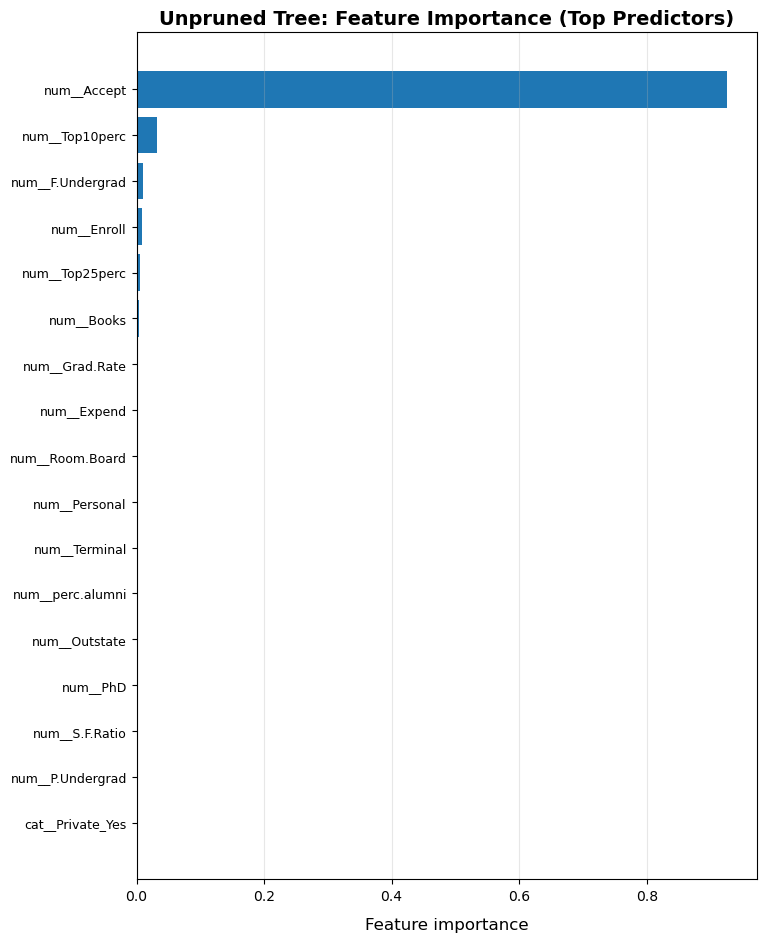

In [20]:
# Feature Importance
q1b_feature_names = q1b_tree.named_steps["preprocess"].get_feature_names_out()
q1b_importances = q1b_model.feature_importances_

# Sanity check
assert np.isclose(q1b_importances.sum(), 1.0), "Tree importances do not sum to 1."

# Save plot
_ =save_importance_plot(
    q1b_feature_names,
    q1b_importances,
    filename_png="q1b_tree_importance.png",
    title="Unpruned Tree: Feature Importance (Top Predictors)",
    top_k=None,
)

In [21]:
# Save table
q1b_imp_tbl = save_importance_table(
    q1b_feature_names,
    q1b_importances,
    filename_tex="q1b_tree_importance.tex",
    caption="Top predictors by feature importance for the unpruned regression tree.",
    label="tab:q1b-tree-importance",
    top_k=None,
)

if VERBOSE:
    display(q1b_imp_tbl)

,Predictor,Importance
0,num__Accept,0.926011
1,num__Top10perc,0.031780
2,num__F.Undergrad,0.009625
3,num__Enroll,0.008054
4,num__Top25perc,0.005733
5,num__Books,0.004088
6,num__Grad.Rate,0.002666
7,num__Expend,0.002179
8,num__Room.Board,0.002065
9,num__Personal,0.001966


### **1(c)** Pruned Regression Tree via Cross-Validation

In [22]:
#  Cost-Complexity Pruning Path

# Fit Unpruned Tree on Training Data
q1c_tree_unpruned = Pipeline(
    steps=[
        ("preprocess", q1_preprocess),
        ("model", DecisionTreeRegressor(random_state=SEED)),
    ]
)
q1c_tree_unpruned.fit(q1_X_train, q1_y_train)

q1c_unpruned_model = q1c_tree_unpruned.named_steps["model"]
assert hasattr(q1c_unpruned_model, "tree_"), "Unpruned tree was not fit correctly."

# Get Transformed Training Matrix to Compute Pruning Path
q1c_X_train_trans = q1c_tree_unpruned.named_steps["preprocess"].transform(q1_X_train)

# Sanity check
assert (
    q1c_X_train_trans.shape[0] == q1_X_train.shape[0]
), "Row mismatch after preprocessing."

# Compute Pruning Path for the Fitted (Unpruned) Tree
q1c_path = q1c_unpruned_model.cost_complexity_pruning_path(
    q1c_X_train_trans, q1_y_train
)
q1c_ccp_alphas = q1c_path.ccp_alphas
q1c_impurities = q1c_path.impurities

# Sanity checks
assert q1c_ccp_alphas.ndim == 1
assert len(q1c_ccp_alphas) == len(q1c_impurities)
assert (q1c_ccp_alphas >= 0).all()

vprint(f"Pruning path length: {len(q1c_ccp_alphas)}")

Pruning path length: 598


In [23]:
# K-fold CV on Training Data Choose Best alpha
q1c_kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Drop Last alpha (stump)
q1c_alphas = q1c_ccp_alphas[:-1].astype(float)
assert len(q1c_alphas) > 0, "No candidate alphas found after dropping the last alpha."

q1c_cv_rows = []

for a in q1c_alphas:
    q1c_tree = Pipeline(
        steps=[
            ("preprocess", q1_preprocess),
            ("model", DecisionTreeRegressor(random_state=SEED, ccp_alpha=float(a))),
        ]
    )
    # CV MSE (negative in sklearn)
    cv_neg_mse = cross_val_score(
        q1c_tree,
        q1_X_train,
        q1_y_train,
        cv=q1c_kf,
        scoring="neg_mean_squared_error",
    )

    cv_mse = -cv_neg_mse
    q1c_cv_rows.append(
        {
            "ccp_alpha": float(a),
            "cv_mse_mean": float((-cv_neg_mse).mean()),
            "cv_mse_std": float((-cv_neg_mse).std(ddof=1)),
        }
    )

q1c_cv_results = pd.DataFrame(q1c_cv_rows)

# Sanity checks
assert q1c_cv_results.shape[0] == len(q1c_alphas)
assert (q1c_cv_results["ccp_alpha"] >= 0).all()

In [24]:
# Choose alpha with Minimum Mean CV MSE
q1c_best_idx = q1c_cv_results["cv_mse_mean"].idxmin()
q1c_best_alpha = float(q1c_cv_results.loc[q1c_best_idx, "ccp_alpha"])

assert q1c_best_alpha >= 0
vprint(f"Q1(c) selected alpha: {q1c_best_alpha:.6f}")

if VERBOSE:
    display(q1c_cv_results.sort_values("cv_mse_mean").head(10))

Q1(c) selected alpha: 9185.213666


,ccp_alpha,cv_mse_mean,cv_mse_std
568,9185.213666,3.435400e+06,6.294296e+06
566,6762.505896,3.447499e+06,6.284538e+06
565,6738.881914,3.447499e+06,6.284538e+06
587,86865.120888,3.452692e+06,5.401558e+06
564,6122.254428,3.460001e+06,6.282183e+06
576,23670.315298,3.461925e+06,6.302840e+06
569,11383.254974,3.461988e+06,6.288410e+06
582,31418.654844,3.464394e+06,6.278363e+06
577,24528.794667,3.465311e+06,6.303002e+06
583,32087.787444,3.465357e+06,6.277847e+06


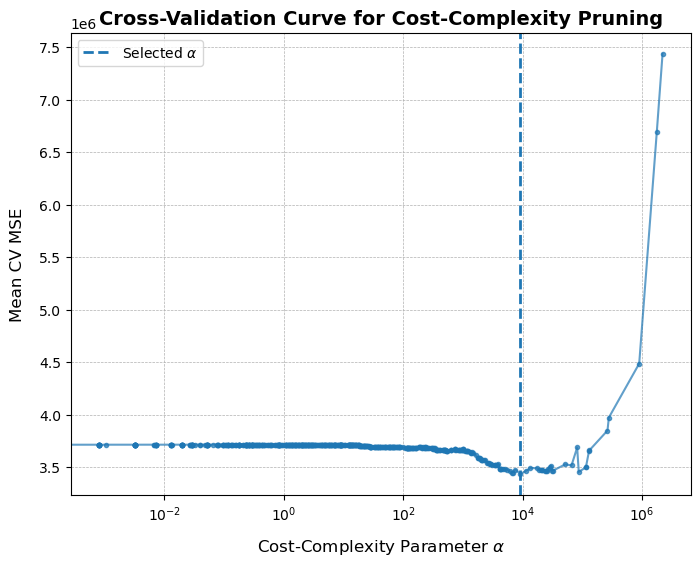

In [25]:
# CV curve figure
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(
    q1c_cv_results["ccp_alpha"],
    q1c_cv_results["cv_mse_mean"],
    marker="o",
    markersize=3,
    alpha=0.7,
    linestyle="-",
    linewidth=1.5,
)

# Mark Selected alpha
ax.axvline(
    q1c_best_alpha,
    linestyle="--",
    linewidth=2,
    label=r"Selected $\alpha$",
)

ax.set_xscale("log")
ax.set_xlabel(r"Cost-Complexity Parameter $\alpha$", fontsize=12, labelpad=10)
ax.set_ylabel("Mean CV MSE", fontsize=12, labelpad=10)
ax.set_title(
    "Cross-Validation Curve for Cost-Complexity Pruning", fontsize=14, fontweight="bold"
)

ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

_ = save_fig(fig, "q1c_cv_curve.png")

In [26]:
# Fit Pruned Tree using Best alpha

q1c_tree_pruned = Pipeline(
    steps=[
        ("preprocess", q1_preprocess),
        ("model", DecisionTreeRegressor(random_state=SEED, ccp_alpha=q1c_best_alpha)),
    ]
)

q1c_tree_pruned.fit(q1_X_train, q1_y_train)

q1c_pruned_model = q1c_tree_pruned.named_steps["model"]
assert hasattr(q1c_pruned_model, "tree_"), "Pruned tree was not fit correctly."

In [27]:
# Train/Test Performance
q1c_y_train_pred = q1c_tree_pruned.predict(q1_X_train)
q1c_y_test_pred = q1c_tree_pruned.predict(q1_X_test)

q1c_train_mse = float(mean_squared_error(q1_y_train, q1c_y_train_pred))
q1c_test_mse = float(mean_squared_error(q1_y_test, q1c_y_test_pred))

assert q1c_train_mse >= 0 and q1c_test_mse >= 0

# RMSE sanity checks
q1c_train_rmse = float(np.sqrt(q1c_train_mse))
q1c_test_rmse = float(np.sqrt(q1c_test_mse))

if VERBOSE:
    vprint(f"Train RMSE: {q1c_train_rmse:.4f}")
    vprint(f"Test  RMSE: {q1c_test_rmse:.4f}")

Train RMSE: 450.9707
Test  RMSE: 1266.1494


In [28]:
q1c_mse_tbl = pd.DataFrame(
    {"Metric": ["Train MSE", "Test MSE"], "Value": [q1c_train_mse, q1c_test_mse]}
)

_ = save_tex_table(
    q1c_mse_tbl,
    "q1c_tree_mse.tex",
    caption="Train and test mean squared error (MSE) for the pruned regression tree.",
    label="tab:q1c-tree-mse",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q1c_mse_tbl)

,Metric,Value
0,Train MSE,2.033746e+05
1,Test MSE,1.603134e+06


In [29]:
# Extract Pruned Depth and Num Leaves
q1c_pruned_depth = int(q1c_pruned_model.get_depth())
q1c_pruned_n_leaves = int(q1c_pruned_model.get_n_leaves())

assert q1c_pruned_depth >= 0
assert q1c_pruned_n_leaves >= 1

In [30]:
# Comparison Table: Unpruned vs Pruned Trees
q1c_tree_comparison_tbl = pd.DataFrame(
    {
        "Quantity": [
            "Tree depth",
            "Number of terminal nodes (leaves)",
            "Train MSE",
            "Test MSE",
        ],
        "Unpruned Tree": [
            q1b_depth,
            int(q1b_n_leaves),
            q1b_train_mse,
            q1b_test_mse,
        ],
        "Pruned Tree": [
            q1c_pruned_depth,
            int(q1c_pruned_n_leaves),
            q1c_train_mse,
            q1c_test_mse,
        ],
    }
)

_ = save_tex_table(
    q1c_tree_comparison_tbl,
    "q1c_tree_comparison.tex",
    caption="Comparison of unpruned and pruned regression trees for predicting applications.",
    label="tab:q1c-tree-comparison",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q1c_tree_comparison_tbl)

,Quantity,Unpruned Tree,Pruned Tree
0,Tree depth,2.100000e+01,7.000000e+00
1,Number of terminal nodes (leaves),6.140000e+02,3.000000e+01
2,Train MSE,0.000000e+00,2.033746e+05
3,Test MSE,1.851206e+06,1.603134e+06


In [31]:
# Variable Importance
q1c_feature_names = q1c_tree_pruned.named_steps["preprocess"].get_feature_names_out()
q1c_importances = q1c_tree_pruned.named_steps["model"].feature_importances_

# Sanity checks
assert len(q1c_feature_names) == len(q1c_importances)
assert (q1c_importances >= 0).all()
assert np.isclose(
    float(q1c_importances.sum()), 1.0
), f"Feature importances sum to {q1c_importances.sum():.6f}, expected 1.0"

In [32]:
# Save LaTeX importance table
q1c_importance_tbl = save_importance_table(
    q1c_feature_names,
    q1c_importances,
    filename_tex="q1c_pruned_tree_importance.tex",
    caption="Variable importances from the pruned regression tree. Predictors with zero importance were not used in any split.",
    label="tab:q1c-pruned-tree-importance",
    top_k=None,
)

if VERBOSE:
    display(q1c_importance_tbl)

,Predictor,Importance
0,num__Accept,0.935777
1,num__Top10perc,0.031603
2,num__F.Undergrad,0.008687
3,num__Enroll,0.007633
4,num__Top25perc,0.005389
5,num__Books,0.003415
6,num__Grad.Rate,0.002012
7,num__Expend,0.001619
8,num__Personal,0.001563
9,num__Terminal,0.001414


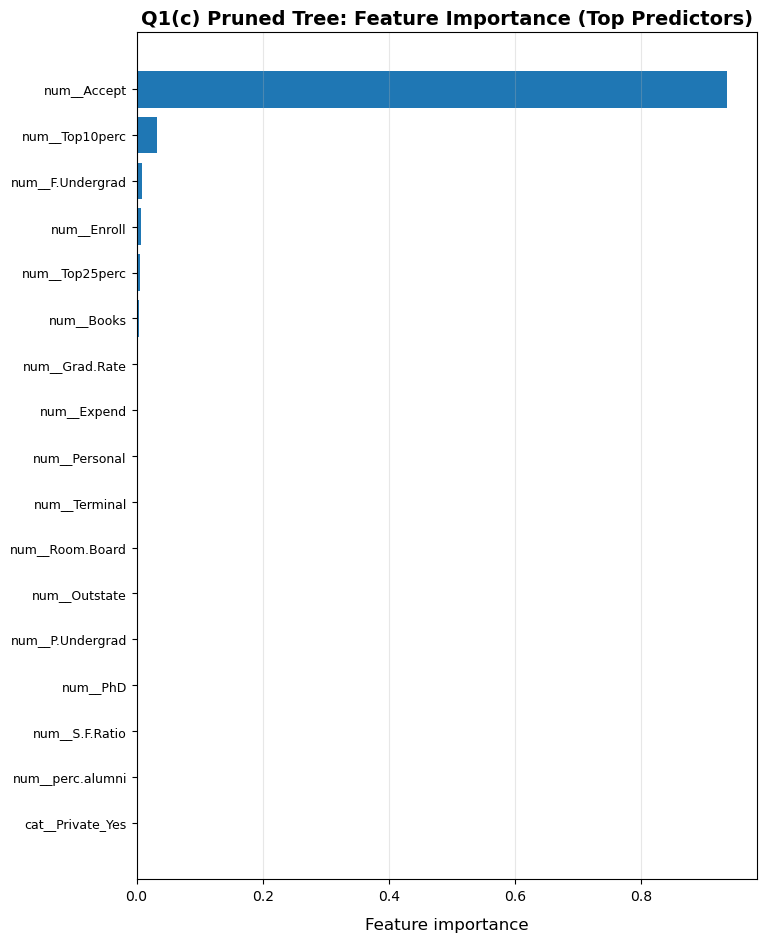

In [33]:
# Save importance plot
_ = save_importance_plot(
    q1c_feature_names,
    q1c_importances,
    filename_png="q1c_pruned_tree_importance.png",
    title="Q1(c) Pruned Tree: Feature Importance (Top Predictors)",
    top_k=None,
)

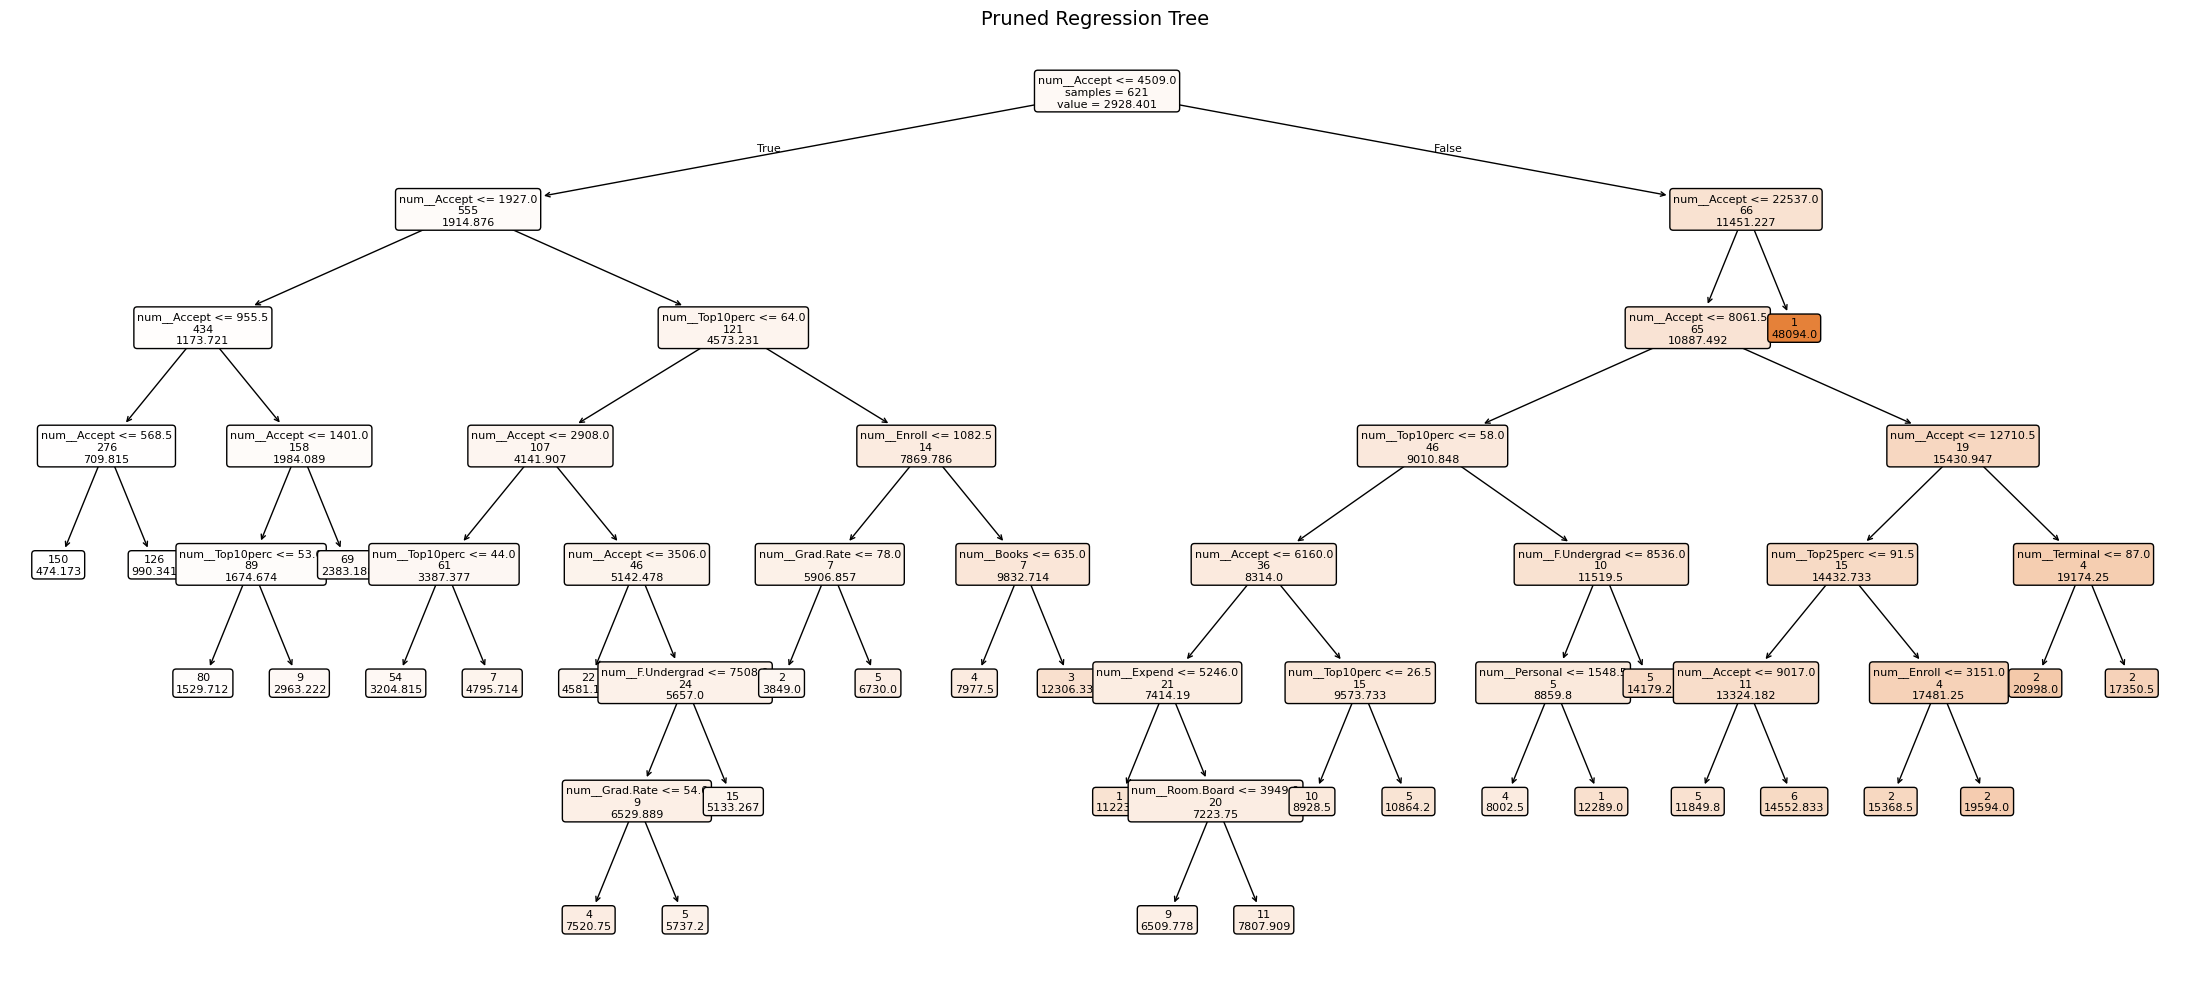

In [34]:
# Pruned Tree Plot: Feature + Threshold Labels  Only
q1c_pruned_model = q1c_tree_pruned.named_steps["model"]
q1c_feature_names = q1c_tree_pruned.named_steps["preprocess"].get_feature_names_out()

fig, ax = plt.subplots(figsize=(22, 10))

plot_tree(
    q1c_pruned_model,
    feature_names=q1c_feature_names,
    filled=True,
    rounded=True,
    impurity=False,
    node_ids=False,
    proportion=False, 
    label="root",  
    fontsize=8,
    ax=ax,
)

ax.set_title("Pruned Regression Tree", fontsize=14)
plt.tight_layout()

_ = save_fig(fig, "q1c_pruned_tree.png")

### **1(d)** Bagging Regression Trees

In [35]:
# Fit Bagging Models
q1d_results = []

for B in [500, 1000]:
    q1d_bag = Pipeline(
        steps=[
            ("preprocess", q1_preprocess),
            (
                "model",
                BaggingRegressor(
                    estimator=DecisionTreeRegressor(random_state=SEED),
                    n_estimators=B,
                    random_state=SEED,
                    n_jobs=-1,
                ),
            ),
        ]
    )

    q1d_bag.fit(q1_X_train, q1_y_train)

    q1d_y_train_pred = q1d_bag.predict(q1_X_train)
    q1d_y_test_pred = q1d_bag.predict(q1_X_test)

    q1d_train_mse = float(mean_squared_error(q1_y_train, q1d_y_train_pred))
    q1d_test_mse = float(mean_squared_error(q1_y_test, q1d_y_test_pred))

    assert q1d_train_mse >= 0 and q1d_test_mse >= 0

    q1d_results.append(
        {
            "B": B,
            "Train MSE": q1d_train_mse,
            "Test MSE": q1d_test_mse,
        }
    )

In [36]:
q1d_metrics_df = pd.DataFrame(q1d_results).set_index("B").T
q1d_metrics_df.columns = [f"B={int(c)}" for c in q1d_metrics_df.columns]

_ = save_tex_table(
    q1d_metrics_df.reset_index().rename(columns={"index": "Metric"}),
    "q1d_bagging_mse.tex",
    caption="Train and test mean squared error (MSE) for bagging regression trees with $B=500$ and $B=1000$.",
    label="tab:q1d-bagging-mse",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q1d_metrics_df)

,B=500,B=1000
Train MSE,324906.519582,331497.465988
Test MSE,991954.086290,994984.315733


In [37]:
# RMSE sanity checks
q1d_rmse = {
    "B=500": float(np.sqrt(q1d_metrics_df.loc["Test MSE", "B=500"])),
    "B=1000": float(np.sqrt(q1d_metrics_df.loc["Test MSE", "B=1000"])),
}

if VERBOSE:
    print(
        f"Test RMSE: \n\tB=500 -> {q1d_rmse['B=500']:.4f}\n\tB=1000 -> {q1d_rmse['B=1000']:.4f}"
    )

Test RMSE: 
	B=500 -> 995.9689
	B=1000 -> 997.4890


In [38]:
# Using B=500 fitted model for importance reporting
# Quick re-fit to capture the object
q1d_bag_500 = Pipeline(
    steps=[
        ("preprocess", q1_preprocess),
        (
            "model",
            BaggingRegressor(
                estimator=DecisionTreeRegressor(random_state=SEED),
                n_estimators=500,
                random_state=SEED,
                n_jobs=-1,
            ),
        ),
    ]
)
q1d_bag_500.fit(q1_X_train, q1_y_train)

q1d_feature_names = q1d_bag_500.named_steps["preprocess"].get_feature_names_out()
q1d_estimators = q1d_bag_500.named_steps["model"].estimators_

# Average Importances Across Trees
q1d_importances = np.mean(
    [est.feature_importances_ for est in q1d_estimators],
    axis=0,
)

assert len(q1d_feature_names) == len(q1d_importances)
assert (q1d_importances >= 0).all()
assert np.isclose(
    q1d_importances.sum(), 1.0
), f"Importances sum to {q1d_importances.sum():.6f}, expected ~1.0"

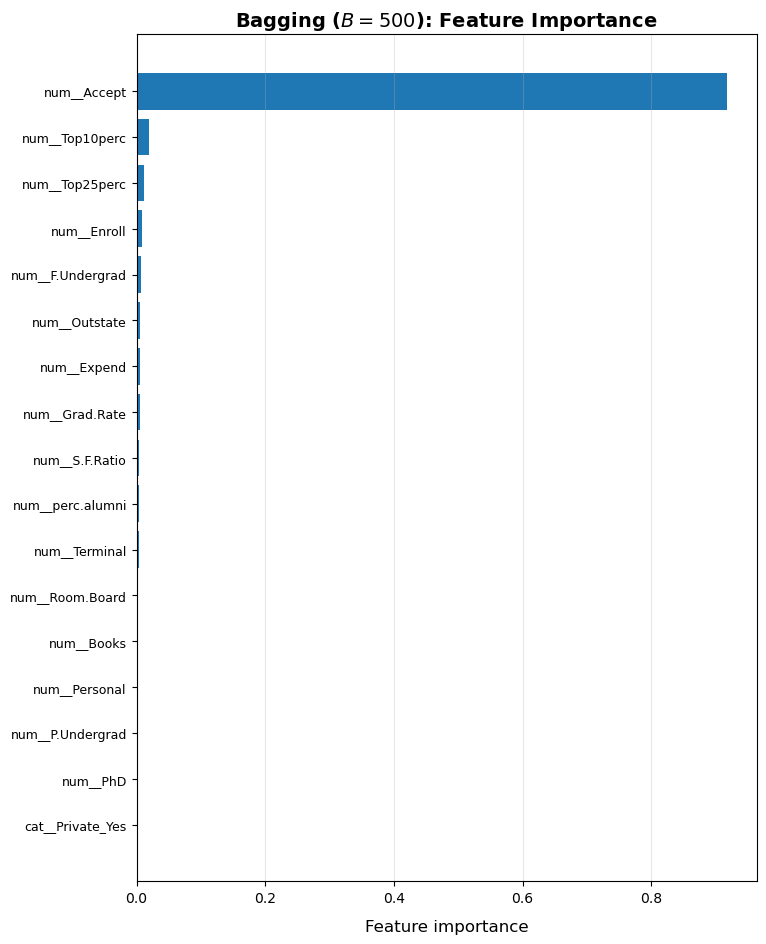

In [39]:
# Variable Importance Plot
q1d_imp_plot = save_importance_plot(
    q1d_feature_names,
    q1d_importances,
    filename_png="q1d_bagging_importance.png",
    title=r"Bagging ($B=500$): Feature Importance",
    top_k=None,
)

In [40]:
# Variable Importance Table
q1d_imp_tbl = save_importance_table(
    q1d_feature_names,
    q1d_importances,
    filename_tex="q1d_bagging_importance.tex",
    caption=f"Top predictors by feature importance for bagging regression trees ($B=500$).",
    label="tab:q1d-bagging-importance",
    top_k=None,
)

if VERBOSE:
    display(q1d_imp_tbl)

,Predictor,Importance
0,num__Accept,0.917838
1,num__Top10perc,0.019137
2,num__Top25perc,0.010738
3,num__Enroll,0.008575
4,num__F.Undergrad,0.006565
5,num__Outstate,0.005743
6,num__Expend,0.005499
7,num__Grad.Rate,0.005421
8,num__S.F.Ratio,0.003130
9,num__perc.alumni,0.003124


In [41]:
# Sanity Check: Ensure plot and table are built from same top_k ordering
assert q1d_imp_tbl["Predictor"].tolist() == q1d_imp_plot["Predictor"].tolist()

### **1(e)** Random Forests

In [42]:
# Random Forest (m ≈ p/3)
# B = 500 and B = 1000

# Fit random forests
def fit_random_forest(n_estimators, *, max_features=3):
    rf = Pipeline(
        steps=[
            ("preprocess", q1_preprocess),
            (
                "model",
                RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_features=max_features,
                    random_state=SEED,
                    n_jobs=-1,
                ),
            ),
        ]
    )

    rf.fit(q1_X_train, q1_y_train)

    yhat_train = rf.predict(q1_X_train)
    yhat_test = rf.predict(q1_X_test)

    train_mse = mean_squared_error(q1_y_train, yhat_train)
    test_mse = mean_squared_error(q1_y_test, yhat_test)

    assert train_mse >= 0 and test_mse >= 0

    return rf, float(train_mse), float(test_mse)


q1e_rf_500, q1e_train_mse_500, q1e_test_mse_500 = fit_random_forest(500, max_features=3)
q1e_rf_1000, q1e_train_mse_1000, q1e_test_mse_1000 = fit_random_forest(1000, max_features=3)

In [43]:
# Build MSE table (rows = metrics, cols = B)
q1e_mse_tbl = pd.DataFrame(
    {
        "B=500": [q1e_train_mse_500, q1e_test_mse_500],
        "B=1000": [q1e_train_mse_1000, q1e_test_mse_1000],
    },
    index=["Train MSE", "Test MSE"],
)

_ = save_tex_table(
    q1e_mse_tbl.reset_index().rename(columns={"index": "Metric"}),
    "q1e_random_forest_mse.tex",
    caption="Train and test mean squared error (MSE) for random forests with $m=3$ predictors considered at each split.",
    label="tab:q1e-rf-mse",
    float_fmt="%.4f",
    index=False,
    escape_underscore_cols=("Metric",),
)

if VERBOSE:
    display(q1e_mse_tbl)

,B=500,B=1000
Train MSE,3.829652e+05,3.911695e+05
Test MSE,1.077786e+06,1.039994e+06


In [44]:
# RMSE in text only
q1e_test_rmse_500 = float(np.sqrt(q1e_test_mse_500))
q1e_test_rmse_1000 = float(np.sqrt(q1e_test_mse_1000))

if VERBOSE:
    print("Test RMSE:")
    print(f"\tB=500  -> {q1e_test_rmse_500:.4f}")
    print(f"\tB=1000 -> {q1e_test_rmse_1000:.4f}")

Test RMSE:
	B=500  -> 1038.1648
	B=1000 -> 1019.8008


In [45]:
# Variable importance using B=1000 model
q1e_feature_names = q1e_rf_1000.named_steps["preprocess"].get_feature_names_out()
q1e_importances = q1e_rf_1000.named_steps["model"].feature_importances_

# Sanity Checks
assert len(q1e_feature_names) == len(q1e_importances)
assert np.isclose(
    q1e_importances.sum(), 1.0
), f"Importances sum to {q1e_importances.sum():.6f}, expected 1.0"
assert (q1e_importances >= 0).all()

In [46]:
# Variable Importance Table
q1e_importance_df = save_importance_table(
    q1e_feature_names,
    q1e_importances,
    filename_tex="q1e_random_forest_importance.tex",
    caption="Predictors ranked by impurity-based feature importance for the random forest ($B=1000$, $m=3$).",
    label="tab:q1e-rf-importance",
    top_k=None,
)

if VERBOSE:
    display(q1e_importance_df)

,Predictor,Importance
0,num__Accept,0.261689
1,num__Enroll,0.202723
2,num__F.Undergrad,0.168747
3,num__P.Undergrad,0.056707
4,num__Top25perc,0.032524
5,num__PhD,0.031691
6,num__Grad.Rate,0.030244
7,num__Expend,0.028889
8,cat__Private_Yes,0.028347
9,num__Top10perc,0.028345


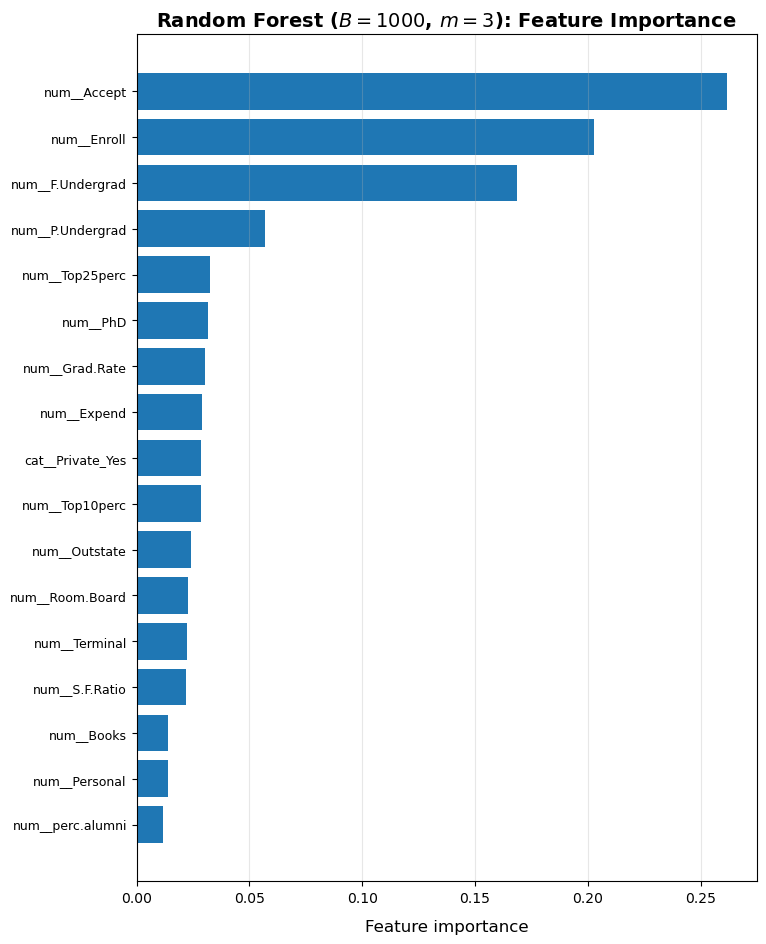

In [47]:
# Variable Importance Plot
_ = save_importance_plot(
    q1e_importance_df["Predictor"].to_numpy(),
    q1e_importance_df["Importance"].to_numpy(),
    filename_png="q1e_random_forest_importance.png",
    title=r"Random Forest ($B=1000$, $m=3$): Feature Importance",
    top_k=None,
)

### **1(f)** Method Comparison and Recommendation

In [48]:
# Comparison Table
def _safe_float(x):
    """Convert scalar to float if possible; otherwise return np.nan."""
    try:
        if x is None:
            return np.nan
        return float(x)
    except Exception:
        return np.nan

# Collect results

# Pull bagging metrics from table q1d_metrics_df 
q1d_train_mse_500 = float(q1d_metrics_df.loc["Train MSE", "B=500"])
q1d_test_mse_500  = float(q1d_metrics_df.loc["Test MSE",  "B=500"])

q1f_rows = [
    {
        "Method": "Linear regression",
        "Train MSE": _safe_float(globals().get("q1a_train_mse")),
        "Test MSE": _safe_float(globals().get("q1a_test_mse")),
    },
    {
        "Method": "Unpruned tree",
        "Train MSE": _safe_float(globals().get("q1b_train_mse")),
        "Test MSE": _safe_float(globals().get("q1b_test_mse")),
    },
    {
        "Method": "Pruned tree (CV)",
        "Train MSE": _safe_float(globals().get("q1c_train_mse")),
        "Test MSE": _safe_float(globals().get("q1c_test_mse")),
    },
    {
        "Method": "Bagging (B=500)",
        "Train MSE": _safe_float(globals().get("q1d_train_mse_500")),
        "Test MSE": _safe_float(globals().get("q1d_test_mse_500")),
    },
    {
        "Method": "Random forest (B=1000, m=3)",
        "Train MSE": _safe_float(globals().get("q1e_train_mse_1000")),
        "Test MSE": _safe_float(globals().get("q1e_test_mse_1000")),
    },
]

q1f_compare_tbl = pd.DataFrame(q1f_rows)

# Sort by Test MSE for easy comparison
q1f_compare_tbl_mse_only = q1f_compare_tbl.sort_values("Test MSE", ascending=True)

# Save LaTeX table
save_tex_table(
    q1f_compare_tbl_mse_only,
    "q1f_all_methods_mse.tex",
    caption="Train and test mean squared error (MSE) for all methods.",
    label="tab:q1f-all-methods",
    float_fmt="%.4f",
    index=False,
    escape_underscore_cols=("Method",),
)

if VERBOSE:
    display(q1f_compare_tbl_mse_only)

,Method,Train MSE,Test MSE
3,Bagging (B=500),324906.519582,9.919541e+05
4,"Random forest (B=1000, m=3)",391169.521522,1.039994e+06
0,Linear regression,990105.966170,1.492443e+06
2,Pruned tree (CV),203374.614348,1.603134e+06
1,Unpruned tree,0.000000,1.851206e+06


---
---

## **Question 2:** Business School Admissions

Consider the business school admission data available in the `admission.csv`. The admission officer of a business school has used an “index” of undergraduate grade point average (GPA, \(X_1\)) and graduate management aptitude test (GMAT, \(X_2\)) scores to help decide which applicants should be admitted to the school’s graduate programs. This index is used to categorize each applicant into one of three groups – admit (group 1), do not admit (group 2), and borderline (group 3).

We will take the last four observations in each category as test data and the remaining observations as training data.

- **Part (a):** Perform an exploratory analysis of the training data by examining appropriate plots and comment on how helpful these predictors may be in predicting response.  

- **Part (b):** Perform an LDA using the training data. Superimpose the decision boundary on an appropriate display of the data. Does the decision boundary seem sensible? In addition, compute the confusion matrix and overall misclassification rate based on both training
and test data. What do you observe?  

- **Part (c):** Repeat (b) using QDA. 

- **Part (d):** Fit a KNN with \(K\) chosen optimally using test error rate. Report error rate, sensitivity, specificity, and AUC for the optimal KNN based on the training data. Also, report its estimated test error rate.  

- **Part (e):** Compare the results in (b), (c) and (d). Which classifier would you recommend? Justify your conclusions.


### Q2-Specific Helper Functions and Shared Objects

In [75]:
# Color/label mapping for groups
q2_labels = {1: "Admit", 2: "Not Admit", 3: "Border"}
q2_colors = {1: "tab:blue", 2: "tab:orange", 3: "tab:green"}
q2_order = [2, 3, 1]

# Names in order: Not Admit, Border, Admit
q2_group_names = [q2_labels[g] for g in q2_order]

# AUC label Order
q2_auc_order = [1, 2, 3]

In [49]:
# PLOTTING HELPERS


# Helper Function for scatter plots
def plot_q2_scatter(df, ax, order, labels, colors, title=None, alpha=0.7):
    """Scatter plot of GPA vs GMAT colored by admission group."""
    for g in order:
        subset = df[df["Group"] == g]
        ax.scatter(
            subset["GPA"],
            subset["GMAT"],
            label=labels[g],
            color=colors[g],
            alpha=alpha,
            edgecolor="k",
            s=60,
        )
    ax.set_xlabel("Undergraduate GPA", fontsize=12, labelpad=10)
    ax.set_ylabel("GMAT Score", fontsize=12, labelpad=10)
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(True)


# Mesh for plotting
def build_gpa_gmat_mesh(df, *, gpa_pad=0.05, gmat_pad=10, n=300):
    gpa_min, gpa_max = df["GPA"].min() - gpa_pad, df["GPA"].max() + gpa_pad
    gmat_min, gmat_max = df["GMAT"].min() - gmat_pad, df["GMAT"].max() + gmat_pad

    xx, yy = np.meshgrid(
        np.linspace(gpa_min, gpa_max, n),
        np.linspace(gmat_min, gmat_max, n),
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, grid

In [76]:
#  METRICS + TABLE HELPERS


def q2_misclass_rate(y_true, y_pred):
    """Misclassification rate."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(y_pred != y_true))


def q2_confusion_and_ovr_metrics(y_true, y_pred, *, order):
    """
    Given y_true/y_pred, compute:
      - confusion matrix in `order`
      - per-class OvR sensitivity (recall)
      - per-class OvR specificity
      - macro sensitivity
      - macro specificity
    Returns: cm, sens, spec, sens_macro, spec_macro
    """
    cm = confusion_matrix(y_true, y_pred, labels=order)

    n = cm.sum()
    rowsum = cm.sum(axis=1)  # actual totals per class
    colsum = cm.sum(axis=0)  # predicted totals per class
    diag = np.diag(cm)

    # Sensitivity (OvR) per class: TP / (TP + FN) = diag / rowsum
    with np.errstate(divide="ignore", invalid="ignore"):
        sens = diag / rowsum

        # Specificity (OvR) per class: TN / (TN + FP)
        # TN = n - rowsum - colsum + diag; TN+FP = n - rowsum
        spec = (n - rowsum - colsum + diag) / (n - rowsum)

    sens_macro = float(np.nanmean(sens))
    spec_macro = float(np.nanmean(spec))

    return cm, sens, spec, sens_macro, spec_macro


def q2_align_proba_to_order(proba, model_classes, *, order):
    """
    Align predicted probability columns to `order`.
    `model_classes` is typically model.classes_ (or pipeline.named_steps[...] .classes_).
    Returns numpy array proba_aligned with columns in `order`.
    """
    model_classes = list(model_classes)
    idx = [model_classes.index(c) for c in order]
    return proba[:, idx]


def q2_auc_ovr_macro(y_true, proba_aligned):
    """
    Multiclass AUC (OvR macro). Requires proba_aligned columns match the class order used in y_true labels.
    """
    return float(
        roc_auc_score(y_true, proba_aligned, multi_class="ovr", average="macro")
    )


def q2_compute_split_metrics(*, y_true, y_pred, proba, proba_classes, order):
    """
    Compute all required metrics for a given split (train or test):
      - misclassification rate
      - cm
      - per-class sens/spec
      - macro sens/spec
      - AUC (OvR macro)
    `proba` can be None if model doesn't support predict_proba, but LDA/QDA/KNN do.
    """
    err = q2_misclass_rate(y_true, y_pred)

    cm, sens, spec, sens_macro, spec_macro = q2_confusion_and_ovr_metrics(
        y_true, y_pred, order=order
    )

    auc = np.nan
    if proba is not None:
        proba_aligned_auc = q2_align_proba_to_order(
            proba, proba_classes, order=q2_auc_order
        )
        auc = q2_auc_ovr_macro(y_true, proba_aligned_auc)

    # Sanity Checks
    assert 0.0 <= err <= 1.0
    assert 0.0 <= sens_macro <= 1.0
    assert 0.0 <= spec_macro <= 1.0
    if np.isfinite(auc):
        assert 0.0 <= auc <= 1.0

    return {
        "Error": err,
        "cm": cm,
        "sens": sens,
        "spec": spec,
        "sens_macro": sens_macro,
        "spec_macro": spec_macro,
        "auc_ovr_macro": auc,
    }


def q2_eval_classifier(
    model,
    *,
    X_train,
    y_train,
    X_test,
    y_test,
    order,
    model_name=None,
    proba_class_source=None,
):
    """
    Fit model on train, evaluate on train + test using the same OvR macro metrics.
    Returns dict:
      {
        "name": model_name,
        "train": {...metrics...},
        "test": {...metrics...}
      }

    proba_class_source:
      - None: use model.classes_
      - callable(model)->classes: use for pipelines where classes live at named_steps["knn"].classes_
    """
    model.fit(X_train, y_train)

    # Predict labels
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # Predict probas (LDA/QDA/KNN support predict_proba)
    proba_train = (
        model.predict_proba(X_train) if hasattr(model, "predict_proba") else None
    )
    proba_test = (
        model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    )

    # Locate classes_
    if proba_class_source is None:
        classes_ = getattr(model, "classes_", None)
    else:
        classes_ = proba_class_source(model)

    if proba_train is not None and classes_ is None:
        raise ValueError("Could not find class labels for probability alignment.")

    train_metrics = q2_compute_split_metrics(
        y_true=y_train,
        y_pred=yhat_train,
        proba=proba_train,
        proba_classes=classes_,
        order=order,
    )
    test_metrics = q2_compute_split_metrics(
        y_true=y_test,
        y_pred=yhat_test,
        proba=proba_test,
        proba_classes=classes_,
        order=order,
    )

    return {
        "name": model_name if model_name is not None else type(model).__name__,
        "train": train_metrics,
        "test": test_metrics,
    }

In [ ]:
# TABLE FORMATTING HELPERS

def q2_per_class_table(train_metrics, test_metrics, *, group_names):
    """
    Build a single table with per-class sensitivity/specificity for train and test.
    Rows = classes in q2_order; label them using group_names.
    """
    df = pd.DataFrame(
        {
            "Class": group_names,
            "Sensitivity (Train, OvR)": train_metrics["sens"],
            "Specificity (Train, OvR)": train_metrics["spec"],
            "Sensitivity (Test, OvR)": test_metrics["sens"],
            "Specificity (Test, OvR)": test_metrics["spec"],
        }
    )
    return df


def q2_macro_summary_table(train_metrics, test_metrics):
    """
    Build a compact macro summary table: Metric | Train | Test
    """
    df = pd.DataFrame(
        {
            "Metric": [
                "Misclassification rate",
                "Macro sensitivity",
                "Macro specificity",
                "AUC (OvR macro)",
            ],
            "Train": [
                train_metrics["Error"],
                train_metrics["sens_macro"],
                train_metrics["spec_macro"],
                train_metrics["auc_ovr_macro"],
            ],
            "Test": [
                test_metrics["Error"],
                test_metrics["sens_macro"],
                test_metrics["spec_macro"],
                test_metrics["auc_ovr_macro"],
            ],
        }
    )
    return df


def q2_test_metrics_row(method_name, test_metrics):
    """
    One-row dict for the final comparison table (test-only, macro metrics).
    """
    return {
        "Method": method_name,
        "Test Error": test_metrics["Error"],
        "Sensitivity": test_metrics["sens_macro"],
        "Specificity": test_metrics["spec_macro"],
        "AUC": test_metrics["auc_ovr_macro"],
    }


def q2_build_final_comparison_table(rows):
    """
    rows: list of dicts from q2_test_metrics_row(...)
    Returns DataFrame indexed by Method.
    """
    df = pd.DataFrame(rows).set_index("Method")
    return df

### Data Load, Initial Inspection, Split

In [54]:
# Load data
q2_df = pd.read_csv(DATA_DIR / "admission.csv").copy()

In [56]:
# Initial Checks

# Required columns
q2_required_cols = ["GPA", "GMAT", "Group"]
for c in q2_required_cols:
    assert c in q2_df.columns, f"Missing required column '{c}' in admission.csv"

assert len(q2_df) > 0, "admission.csv appears to be empty."

# Missingness checks
n_missing_q2 = int(q2_df[q2_required_cols].isna().sum().sum())
assert (
    n_missing_q2 == 0
), f"Missing values exist in Q2 required columns: total missing = {n_missing_q2}"

# Sanity Checks
assert pd.api.types.is_numeric_dtype(q2_df["GPA"]), "GPA must be numeric."
assert pd.api.types.is_numeric_dtype(q2_df["GMAT"]), "GMAT must be numeric."

q2_group_levels = sorted(q2_df["Group"].unique().tolist())
assert set(q2_group_levels) == {1, 2, 3}, f"Unexpected Group codes: {q2_group_levels}"

# Range Checks
assert q2_df["GPA"].min() > 0, "GPA min looks invalid (<= 0)."
assert q2_df["GMAT"].min() > 0, "GMAT min looks invalid (<= 0)."

In [57]:
# Initial EDA summary
de_levels = (
    sorted(q2_df["De"].astype(str).unique().tolist()) if "De" in q2_df.columns else []
)
group_levels = sorted(q2_df["Group"].unique().tolist())

class_counts = q2_df["Group"].value_counts().sort_index()

q2_eda_summary = pd.DataFrame(
    {
        "item": [
            "n_rows",
            "n_cols",
            "columns",
            "De_levels" if "De" in q2_df.columns else "De_levels",
            "Group_levels",
            "Group_counts",
        ],
        "value": [
            q2_df.shape[0],
            q2_df.shape[1],
            ", ".join(q2_df.columns.astype(str).tolist()),
            ", ".join(de_levels) if de_levels else "(not present)",
            ", ".join(map(str, group_levels)),
            "; ".join([f"{k}:{v}" for k, v in class_counts.items()]),
        ],
    }
)

if VERBOSE:
    display(q2_eda_summary)

,item,value
0,n_rows,85
1,n_cols,4
2,columns,"GPA, GMAT, De, Group"
3,De_levels,"admit, border, notadmit"
4,Group_levels,"1, 2, 3"
5,Group_counts,1:31; 2:28; 3:26


In [59]:
# Sanity check: Verify categorical labels match numeric group coding
category_map = {"admit": 1, "notadmit": 2, "border": 3}

categories_match = (q2_df["De"].map(category_map) == q2_df["Group"]).all()
assert categories_match, "Mismatch between De labels and Group codes."

In [60]:
# Split:
## Last 4 observations in each category -> test
## Rest of observations -> train

q2_test_idx = q2_df.groupby("Group", sort=False).tail(4).index


q2_train_df = q2_df.drop(index=q2_test_idx).copy()
q2_test_df = q2_df.loc[q2_test_idx].copy()

# Features/labels
q2_X_train = q2_train_df[["GPA", "GMAT"]].to_numpy()
q2_y_train = q2_train_df["Group"].to_numpy()

q2_X_test = q2_test_df[["GPA", "GMAT"]].to_numpy()
q2_y_test = q2_test_df["Group"].to_numpy()

# Checks
assert (
    len(q2_test_df) == 12
), f"Expected 12 test observations (4 per class), got {len(q2_test_df)}."
assert q2_train_df.shape[0] + q2_test_df.shape[0] == q2_df.shape[0]

# Ensure exactly 4 per class in test
q2_test_counts = q2_test_df["Group"].value_counts().sort_index()
assert (
    q2_test_counts == 4
).all(), f"Expected 4 test obs per class; got {q2_test_counts.to_dict()}"

# Ensure train still contains all classes
q2_train_levels = set(q2_train_df["Group"].unique().tolist())
assert q2_train_levels == {
    1,
    2,
    3,
}, f"Training set missing a class. Found: {sorted(q2_train_levels)}"

### **2(a)** Exploratory Data Analysis

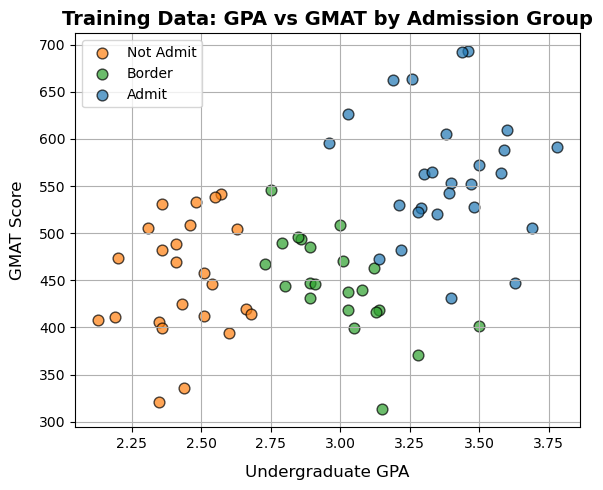

In [63]:
# Scatter plot (Training Data): GPA vs GMAT, colored by groups
fig_scatter, ax_scatter = plt.subplots(figsize=(6, 5))

plot_q2_scatter(
    df=q2_train_df,
    ax=ax_scatter,
    order=q2_order,
    labels=q2_labels,
    colors=q2_colors,
    title="Training Data: GPA vs GMAT by Admission Group",
    alpha=0.7,
)

fig_scatter.tight_layout()

# Save figure
_ = save_fig(
    fig_scatter,
    "q2a_scatter_gpa_gmat_train.png",
)

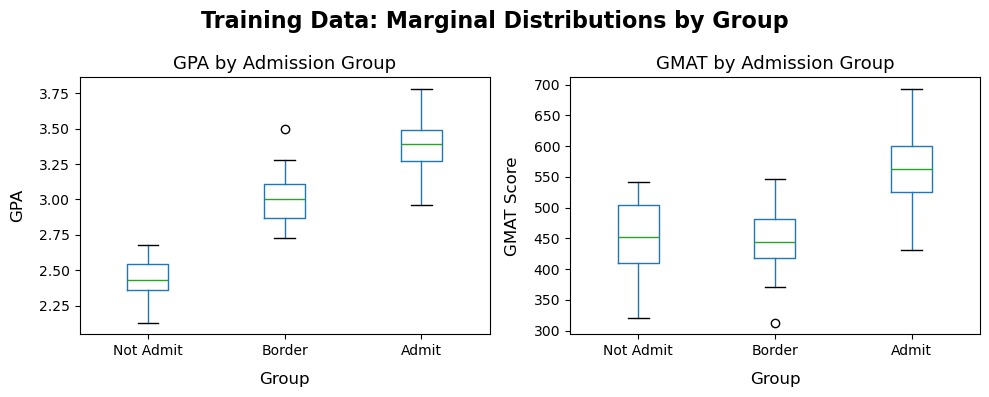

WindowsPath('C:/Users/etoob/OneDrive/Documents/School/STATS/STAT587_DS1/Homeworks/Homework2/STAT587_DS1_HW2/reports/figures/q2a_boxplots_gpa_gmat_train.png')

In [64]:
# Boxplots (Training Data)
q2_train_df_plot = q2_train_df.copy()
q2_train_df_plot["GroupOrdered"] = pd.Categorical(
    q2_train_df_plot["Group"].map(q2_labels),
    categories=[q2_labels[g] for g in q2_order],
    ordered=True,
)

fig_box, axes = plt.subplots(1, 2, figsize=(10, 4))

# Boxplot: GPA by Group
q2_train_df_plot.boxplot(column="GPA", by="GroupOrdered", ax=axes[0], grid=False)
axes[0].set_title("GPA by Admission Group", fontsize=13)
axes[0].set_xlabel("Group", fontsize=12, labelpad=10)
axes[0].set_ylabel("GPA", fontsize=12, labelpad=10)

# Boxplot: GMAT by Group
q2_train_df_plot.boxplot(column="GMAT", by="GroupOrdered", ax=axes[1], grid=False)
axes[1].set_title("GMAT by Admission Group", fontsize=13)
axes[1].set_xlabel("Group", fontsize=12, labelpad=10)
axes[1].set_ylabel("GMAT Score", fontsize=12, labelpad=10)

fig_box.suptitle(
    "Training Data: Marginal Distributions by Group", fontsize=16, fontweight="bold"
)
fig_box.tight_layout()


# Save figure
_ = save_fig(
    fig_box,
    "q2a_boxplots_gpa_gmat_train.png",
)

### **2(b)** Linear Discriminant Analysis (LDA)

In [77]:
# Fit LDA + Evaluation
q2_lda = LinearDiscriminantAnalysis()

q2_lda_res = q2_eval_classifier(
    q2_lda,
    X_train=q2_X_train,
    y_train=q2_y_train,
    X_test=q2_X_test,
    y_test=q2_y_test,
    order=q2_order,
    model_name="LDA",
)

q2_lda_train = q2_lda_res["train"]
q2_lda_test = q2_lda_res["test"]

# Sanity checks
assert q2_lda_train["cm"].shape == (3, 3)
assert q2_lda_test["cm"].shape == (3, 3)

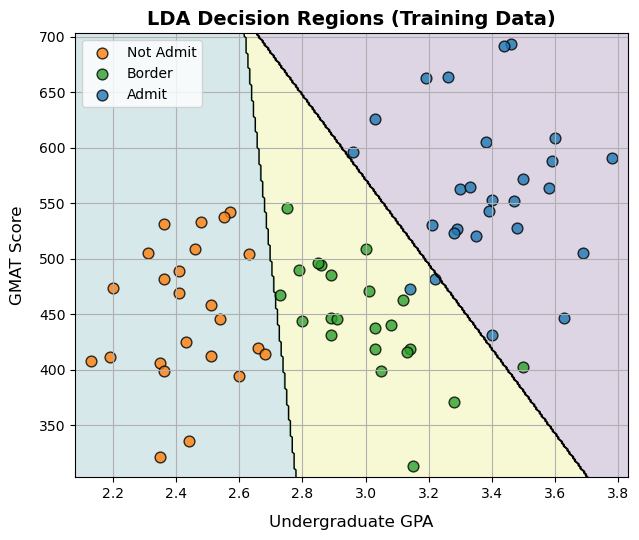

In [78]:
# LDA Decision Boundary Plot (Training Data)
xx, yy, grid = build_gpa_gmat_mesh(q2_train_df)
Z = q2_lda.predict(grid).reshape(xx.shape)

fig_lda, ax_lda = plt.subplots(figsize=(6.5, 5.5))

# Decision regions
ax_lda.contourf(xx, yy, Z, alpha=0.18)

# Decision boundaries (between classes)
ax_lda.contour(xx, yy, Z, levels=[1.5, 2.5], colors="k", linewidths=1)

plot_q2_scatter(
    df=q2_train_df,
    ax=ax_lda,
    order=q2_order,
    labels=q2_labels,
    colors=q2_colors,
    title="LDA Decision Regions (Training Data)",
    alpha=0.8,
)

fig_lda.tight_layout()

_ = save_fig(fig_lda, "q2b_lda_boundary_train.png")

In [79]:
# Confusion Matrices (Train/Test)
q2_lda_cm_train_df = pd.DataFrame(
    q2_lda_train["cm"], index=q2_group_names, columns=q2_group_names
)
q2_lda_cm_test_df = pd.DataFrame(
    q2_lda_test["cm"], index=q2_group_names, columns=q2_group_names
)

save_tex_table(
    q2_lda_cm_train_df,
    "q2b_lda_cm_train.tex",
    caption="LDA confusion matrix (training data). Rows are true classes and columns are predicted classes.",
    label="tab:q2b_lda_cm_train",
    float_fmt=None,
    index=True,
)

save_tex_table(
    q2_lda_cm_test_df,
    "q2b_lda_cm_test.tex",
    caption="LDA confusion matrix (test data). Rows are true classes and columns are predicted classes.",
    label="tab:q2b_lda_cm_test",
    float_fmt=None,
    index=True,
)

if VERBOSE:
    display(q2_lda_cm_train_df)
    display(q2_lda_cm_test_df)

,Not Admit,Border,Admit
Not Admit,24,0,0
Border,0,21,1
Admit,0,2,25


,Not Admit,Border,Admit
Not Admit,2,2,0
Border,0,4,0
Admit,0,1,3


In [83]:
# Per-class OvR Metrics Table (Train/Test)
q2_lda_per_class_df = q2_per_class_table(
    q2_lda_train,
    q2_lda_test,
    group_names=q2_group_names,
)

q2_lda_per_class_train_df = q2_lda_per_class_df[
    ["Class", "Sensitivity (Train, OvR)", "Specificity (Train, OvR)"]
]

q2_lda_per_class_test_df = q2_lda_per_class_df[
    ["Class", "Sensitivity (Test, OvR)", "Specificity (Test, OvR)"]
]

save_tex_table(
    q2_lda_per_class_train_df,
    "q2b_lda_per_class_train.tex",
    caption="LDA per-class sensitivity and specificity (OvR) on the training set.",
    label="tab:q2b_lda_per_class_train",
    float_fmt="%.4f",
    index=False,
)

save_tex_table(
    q2_lda_per_class_test_df,
    "q2b_lda_per_class_test.tex",
    caption="LDA per-class sensitivity and specificity (OvR) on the test set.",
    label="tab:q2b_lda_per_class_test",
    float_fmt="%.4f",
    index=False,
)


if VERBOSE:
    display(q2_lda_per_class_train_df)
    display(q2_lda_per_class_test_df)

,Class,"Sensitivity (Train, OvR)","Specificity (Train, OvR)"
0,Not Admit,1.000000,1.000000
1,Border,0.954545,0.960784
2,Admit,0.925926,0.978261


,Class,"Sensitivity (Test, OvR)","Specificity (Test, OvR)"
0,Not Admit,0.50,1.000
1,Border,1.00,0.625
2,Admit,0.75,1.000


In [81]:
# Macro Summary Table (Train/Test)
q2_lda_macro_df = q2_macro_summary_table(q2_lda_train, q2_lda_test)

save_tex_table(
    q2_lda_macro_df,
    "q2b_lda_macro_summary.tex",
    caption="LDA overall performance metrics on training and test sets. AUC is computed using multiclass OvR macro averaging.",
    label="tab:q2b_lda_macro",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q2_lda_macro_df)

,Metric,Train,Test
0,Misclassification rate,0.041096,0.250000
1,Macro sensitivity,0.960157,0.750000
2,Macro specificity,0.979682,0.875000
3,AUC (OvR macro),0.996550,0.979167


In [82]:
# Collect test metrics for final comparison table
q2_final_rows = []
q2_final_rows.append(q2_test_metrics_row("LDA", q2_lda_test))


### **2(c)** Quadratic Discriminant Analysis (QDA)

In [85]:
# Fit QDA + Evaluation
q2_qda = QuadraticDiscriminantAnalysis()

q2_qda_res = q2_eval_classifier(
    q2_qda,
    X_train=q2_X_train,
    y_train=q2_y_train,
    X_test=q2_X_test,
    y_test=q2_y_test,
    order=q2_order,
    model_name="QDA",
)

q2_qda_train = q2_qda_res["train"]
q2_qda_test = q2_qda_res["test"]

# Sanity checks
assert q2_qda_train["cm"].shape == (3, 3)
assert q2_qda_test["cm"].shape == (3, 3)

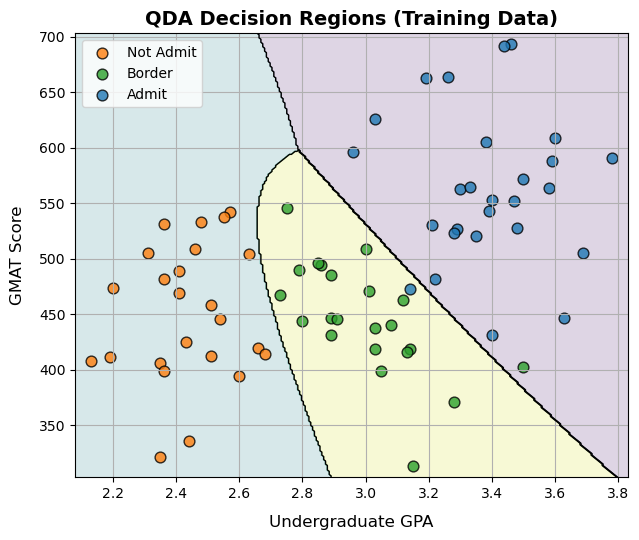

In [86]:
# QDA Decision Boundary Plot (Training Data)
xx, yy, grid = build_gpa_gmat_mesh(q2_train_df)

Z = q2_qda.predict(grid).reshape(xx.shape)

fig_qda, ax_qda = plt.subplots(figsize=(6.5, 5.5))

# Decision regions
ax_qda.contourf(xx, yy, Z, alpha=0.18)

# Decision boundaries (between classes)
ax_qda.contour(xx, yy, Z, levels=[1.5, 2.5], colors="k", linewidths=1)

plot_q2_scatter(
    df=q2_train_df,
    ax=ax_qda,
    order=q2_order,
    labels=q2_labels,
    colors=q2_colors,
    title="QDA Decision Regions (Training Data)",
    alpha=0.8,
)

fig_qda.tight_layout()

_ = save_fig(fig_qda, "q2c_qda_boundary_train.png")

In [88]:
# Confusion Matrices (Train/Test)
q2_qda_cm_train_df = pd.DataFrame(
    q2_qda_train["cm"], index=q2_group_names, columns=q2_group_names
)
q2_qda_cm_test_df = pd.DataFrame(
    q2_qda_test["cm"], index=q2_group_names, columns=q2_group_names
)

save_tex_table(
    q2_qda_cm_train_df,
    "q2c_qda_cm_train.tex",
    caption="QDA confusion matrix (training data). Rows are true classes and columns are predicted classes.",
    label="tab:q2c_qda_cm_train",
    float_fmt=None,
    index=True,
)

save_tex_table(
    q2_qda_cm_test_df,
    "q2c_qda_cm_test.tex",
    caption="QDA confusion matrix (test data). Rows are true classes and columns are predicted classes.",
    label="tab:q2c_qda_cm_test",
    float_fmt=None,
    index=True,
)

if VERBOSE:
    display(q2_qda_cm_train_df)
    display(q2_qda_cm_test_df)

,Not Admit,Border,Admit
Not Admit,24,0,0
Border,0,21,1
Admit,0,1,26


,Not Admit,Border,Admit
Not Admit,2,2,0
Border,0,4,0
Admit,0,0,4


In [89]:
# Per-class OvR Metrics Table (Train/Test)
q2_qda_per_class_df = q2_per_class_table(
    q2_qda_train,
    q2_qda_test,
    group_names=q2_group_names,
)

q2_qda_per_class_train_df = q2_qda_per_class_df[
    ["Class", "Sensitivity (Train, OvR)", "Specificity (Train, OvR)"]
].copy()

q2_qda_per_class_test_df = q2_qda_per_class_df[
    ["Class", "Sensitivity (Test, OvR)", "Specificity (Test, OvR)"]
].copy()

save_tex_table(
    q2_qda_per_class_train_df,
    "q2c_qda_per_class_train.tex",
    caption="QDA per-class sensitivity and specificity (OvR) on the training set.",
    label="tab:q2c_qda_per_class_train",
    float_fmt="%.4f",
    index=False,
)

save_tex_table(
    q2_qda_per_class_test_df,
    "q2c_qda_per_class_test.tex",
    caption="QDA per-class sensitivity and specificity (OvR) on the test set.",
    label="tab:q2c_qda_per_class_test",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q2_qda_per_class_train_df)
    display(q2_qda_per_class_test_df)

,Class,"Sensitivity (Train, OvR)","Specificity (Train, OvR)"
0,Not Admit,1.000000,1.000000
1,Border,0.954545,0.980392
2,Admit,0.962963,0.978261


,Class,"Sensitivity (Test, OvR)","Specificity (Test, OvR)"
0,Not Admit,0.5,1.00
1,Border,1.0,0.75
2,Admit,1.0,1.00


In [90]:
# Macro Summary Table (Train/Test)
q2_qda_macro_df = q2_macro_summary_table(q2_qda_train, q2_qda_test)

save_tex_table(
    q2_qda_macro_df,
    "q2c_qda_macro_summary.tex",
    caption="QDA overall performance metrics on training and test sets. AUC is computed using multiclass OvR macro averaging.",
    label="tab:q2c_qda_macro",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q2_qda_macro_df)

,Metric,Train,Test
0,Misclassification rate,0.027397,0.166667
1,Macro sensitivity,0.972503,0.833333
2,Macro specificity,0.986218,0.916667
3,AUC (OvR macro),0.998840,0.958333


In [91]:
# Collect test metrics for final comparison table
q2_final_rows.append(q2_test_metrics_row("QDA", q2_qda_test))

### **2(d)** K-Nearest Neighbor (KNN)

In [95]:
# Choose K by minimizing Test Misclassification Rate

# Odd k to Reduce class tie frequencies
q2_knn_K_values = list(range(1, 26, 2))
assert all(k % 2 == 1 for k in q2_knn_K_values)

# Choose K* using K-fold CV on training data to avoid test data leakage
q2_knn_cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

q2_knn_cv_rows = []
for K in q2_knn_K_values:
    model = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=K)),
        ]
    )

    cv_acc = cross_val_score(
        model,
        q2_X_train,
        q2_y_train,
        cv=q2_knn_cv,
        scoring="accuracy",
    )

    q2_knn_cv_rows.append(
        {
            "K": K,
            "CV accuracy (mean)": float(np.mean(cv_acc)),
            "CV error (mean)": float(1.0 - np.mean(cv_acc)),
            "CV accuracy (sd)": float(np.std(cv_acc, ddof=1)),
        }
    )

q2_knn_cv_df = pd.DataFrame(q2_knn_cv_rows)

# Choose smallest K among ties
q2_knn_cv_df_sorted = q2_knn_cv_df.sort_values(
    ["CV error (mean)", "K"], ascending=[True, True]
)
q2_knn_best_row = q2_knn_cv_df_sorted.iloc[0]

q2_knn_K_star = int(q2_knn_best_row["K"])
q2_knn_cv_err_star = float(q2_knn_best_row["CV error (mean)"])

vprint(
    f"K* = {q2_knn_K_star}, estimated test error (CV mean) = {q2_knn_cv_err_star:.4f}"
)

# Sanity checks
assert q2_knn_K_star in q2_knn_K_values
assert 0.0 <= q2_knn_cv_err_star <= 1.0

K* = 5, estimated test error (CV mean) = 0.0286


In [96]:
# Save K-sweep results to LaTex table
q2_knn_cv_df_sorted_out = q2_knn_cv_df_sorted.rename(
    columns={
        "CV accuracy (mean)": "CV accuracy (mean)",
        "CV error (mean)": "CV error (mean)",
        "CV accuracy (sd)": "CV accuracy (sd)",
    }
)

save_tex_table(
    q2_knn_cv_df_sorted_out,
    "q2d_knn_k_sweep_cv.tex",
    caption="KNN model selection using training-only 5-fold CV. Reported values are mean CV accuracy/error across folds (and the SD of accuracy).",
    label="tab:q2d_knn_k_sweep_cv",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q2_knn_cv_df_sorted_out)

,K,CV accuracy (mean),CV error (mean),CV accuracy (sd)
2,5,0.971429,0.028571,0.063888
3,7,0.957143,0.042857,0.095831
4,9,0.957143,0.042857,0.095831
5,11,0.957143,0.042857,0.095831
6,13,0.957143,0.042857,0.095831
7,15,0.957143,0.042857,0.095831
8,17,0.943810,0.056190,0.092973
1,3,0.930476,0.069524,0.087521
9,19,0.930476,0.069524,0.087521
0,1,0.917143,0.082857,0.078939


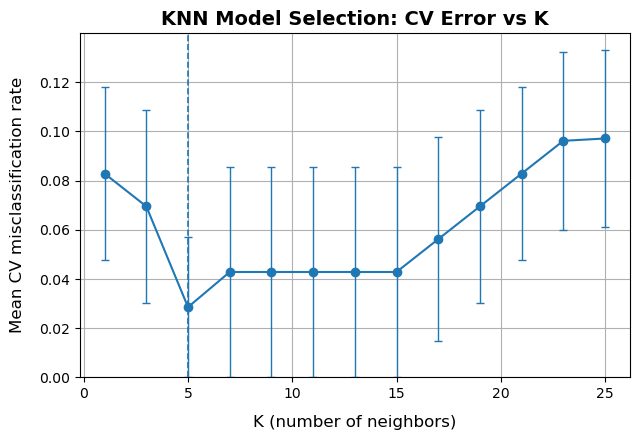

In [112]:
# CV error curve vs K Plot
df_cv = q2_knn_cv_df.sort_values("K").copy()

K_FOLDS = 5  # <-- set this to whatever you used
err_se = df_cv["CV accuracy (sd)"].to_numpy() / np.sqrt(K_FOLDS)

fig_cv, ax_cv = plt.subplots(figsize=(6.5, 4.5))

ax_cv.plot(df_cv["K"], df_cv["CV error (mean)"], marker="o", linewidth=1.5)
ax_cv.axvline(q2_knn_K_star, linestyle="--", linewidth=1.2)

ax_cv.errorbar(
    df_cv["K"],
    df_cv["CV error (mean)"],
    yerr=err_se,
    fmt="none",
    capsize=3,
    linewidth=1.0,
)

ax_cv.set_xlabel("K (number of neighbors)", fontsize=12, labelpad=10)
ax_cv.set_ylabel("Mean CV misclassification rate", fontsize=12, labelpad=10)
ax_cv.set_title("KNN Model Selection: CV Error vs K", fontsize=14, fontweight="bold")
ax_cv.set_ylim(bottom=0)  # guarantees no negative errors
ax_cv.grid(True)

fig_cv.tight_layout()
_ = save_fig(fig_cv, "q2d_knn_cv_curve.png")

In [97]:
# Fit KNN at K* and evaluate on train + test
q2_knn_star = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=q2_knn_K_star)),
    ]
)

q2_knn_res = q2_eval_classifier(
    q2_knn_star,
    X_train=q2_X_train,
    y_train=q2_y_train,
    X_test=q2_X_test,
    y_test=q2_y_test,
    order=q2_order,
    model_name=f"KNN (K={q2_knn_K_star})",
    proba_class_source=lambda m: m.named_steps["knn"].classes_,
)

q2_knn_train = q2_knn_res["train"]
q2_knn_test = q2_knn_res["test"]

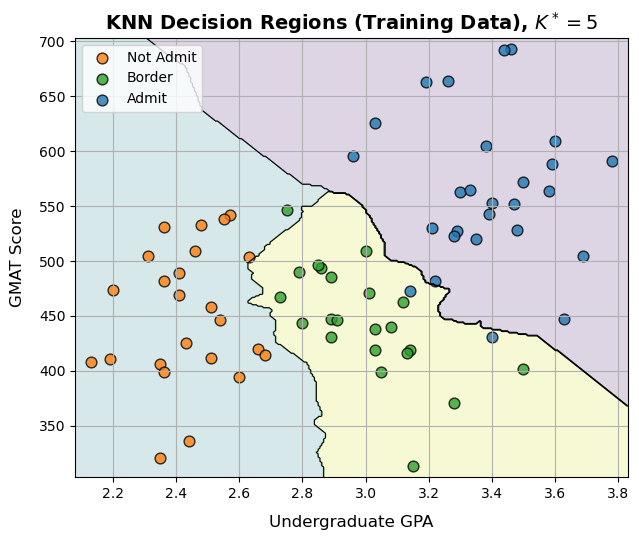

In [111]:
# KNN decision regions at K* (training)
xx, yy, grid = build_gpa_gmat_mesh(q2_train_df)

Z = q2_knn_star.predict(grid).reshape(xx.shape)

fig_knn, ax_knn = plt.subplots(figsize=(6.5, 5.5))

# Decision regions
ax_knn.contourf(xx, yy, Z, alpha=0.18)

# Decision boundaries
ax_knn.contour(xx, yy, Z, levels=[1.5, 2.5], colors="k", linewidths=0.8)

plot_q2_scatter(
    df=q2_train_df,
    ax=ax_knn,
    order=q2_order,
    labels=q2_labels,
    colors=q2_colors,
    title=rf"KNN Decision Regions (Training Data), $K^*={q2_knn_K_star}$",
    alpha=0.8,
)

fig_knn.tight_layout()
_ = save_fig(fig_knn, "q2d_knn_boundary_train.png")

In [102]:
# Confusion matrices (Train/Test)
q2_knn_cm_train_df = pd.DataFrame(
    q2_knn_train["cm"], index=q2_group_names, columns=q2_group_names
)
q2_knn_cm_test_df = pd.DataFrame(
    q2_knn_test["cm"], index=q2_group_names, columns=q2_group_names
)

save_tex_table(
    q2_knn_cm_train_df,
    "q2d_knn_cm_train.tex",
    caption="KNN confusion matrix at $K^*$ (training data). Rows are true classes and columns are predicted classes.",
    label="tab:q2d_knn_cm_train",
    float_fmt=None,
    index=True,
)

save_tex_table(
    q2_knn_cm_test_df,
    "q2d_knn_cm_test.tex",
    caption="KNN confusion matrix at $K^*$ (test data). Rows are true classes and columns are predicted classes.",
    label="tab:q2d_knn_cm_test",
    float_fmt=None,
    index=True,
)

if VERBOSE:
    display(q2_knn_cm_train_df)
    display(q2_knn_cm_test_df)

,Not Admit,Border,Admit
Not Admit,24,0,0
Border,1,21,0
Admit,0,2,25


,Not Admit,Border,Admit
Not Admit,2,2,0
Border,0,4,0
Admit,0,1,3


In [101]:
# Per-class OvR (split train/test tables)
q2_knn_per_class_df = q2_per_class_table(
    q2_knn_train, q2_knn_test, group_names=q2_group_names
)

q2_knn_per_class_train_df = q2_knn_per_class_df[
    ["Class", "Sensitivity (Train, OvR)", "Specificity (Train, OvR)"]
].copy()

q2_knn_per_class_test_df = q2_knn_per_class_df[
    ["Class", "Sensitivity (Test, OvR)", "Specificity (Test, OvR)"]
].copy()

save_tex_table(
    q2_knn_per_class_train_df,
    "q2d_knn_per_class_train.tex",
    caption="KNN per-class sensitivity and specificity (OvR) on the training set at $K^*$.",
    label="tab:q2d_knn_per_class_train",
    float_fmt="%.4f",
    index=False,
)

save_tex_table(
    q2_knn_per_class_test_df,
    "q2d_knn_per_class_test.tex",
    caption="KNN per-class sensitivity and specificity (OvR) on the test set at $K^*$.",
    label="tab:q2d_knn_per_class_test",
    float_fmt="%.4f",
    index=False,
)

if VERBOSE:
    display(q2_knn_per_class_train_df)
    display(q2_knn_per_class_test_df)

,Class,"Sensitivity (Train, OvR)","Specificity (Train, OvR)"
0,Not Admit,1.000000,0.979592
1,Border,0.954545,0.960784
2,Admit,0.925926,1.000000


,Class,"Sensitivity (Test, OvR)","Specificity (Test, OvR)"
0,Not Admit,0.50,1.000
1,Border,1.00,0.625
2,Admit,0.75,1.000


In [ ]:
# Macro summary (train/test)
q2_knn_macro_df = q2_macro_summary_table(q2_knn_train, q2_knn_test)

save_tex_table(
    q2_knn_macro_df,
    "q2d_knn_macro_summary.tex",
    caption="KNN overall performance metrics on training and test sets at $K^*$. AUC is computed using multiclass OvR macro averaging.",
    label="tab:q2d_knn_macro",
    float_fmt="%.4f",
    index=False,
)

q2_knn_est_df = pd.DataFrame(
    {
        "Quantity": ["K*", "Estimated test error (5-fold CV mean)"],
        "Value": [q2_knn_K_star, q2_knn_cv_err_star],
    }
)

if VERBOSE:
    display(q2_knn_macro_df)

,Metric,Train,Test
0,Misclassification rate,0.041096,0.250
1,Macro sensitivity,0.960157,0.750
2,Macro specificity,0.980125,0.875
3,AUC (OvR macro),0.996810,1.000


In [106]:
# Collect test-only metrics for final comparison table
q2_final_rows.append(q2_test_metrics_row("KNN", q2_knn_test))

### **2(e)** Method Comparison and Recommendation

In [72]:
q2_model_comparison_df = pd.DataFrame(
    {
        "Model": ["LDA", "QDA", "KNN (K=3)"],
        "Training Error Rate": [
            q2_lda_train_err,
            q2_qda_train_err,
            q2_knn_train_err3,
        ],
        "Test Error Rate": [
            q2_lda_test_err,
            q2_qda_test_err,
            q2_knn_test_err3,
        ],
    }
)

q2_model_comparison_tex = wrap_table(
    df_to_tabular_tex(q2_model_comparison_df, index=False),
    caption="Comparison of training and test misclassification rates for LDA, QDA, and KNN.",
    label="tab:q2_model_comparison",
)

(TAB_DIR / "q2_model_comparison.tex").write_text(
    q2_model_comparison_tex, encoding="utf-8"
)

387